In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import keras.applications.efficientnet
from keras.applications.efficientnet import EfficientNetB7
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import cv2
from PIL import Image

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.__version__

'2.9.3'

In [4]:
CLAHE_FILTER = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [5]:
data_base_train_folder = 'd:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/Train'
data_base_valid_folder = 'd:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/Validate'
data_base_test_folder = 'd:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/Test'
class_names = ['0', '1']

In [6]:
training_workspace_folder = "d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace/"

In [7]:
def get_confusion_matrix(model, test_data_generator):
    Y_pred = model.predict_generator(test_data_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_data_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [8]:
def create_model_from_inceptionV3_B():
    inceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224,3))
    
    for layer in inceptionV3.layers:
        layer.trainable = False
        
    new_model = tf.keras.models.Sequential([
        inceptionV3,
        #BatchNormalization(),
        Flatten(),  
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),        
        Dropout(0.3),
        Dense(1, activation='softmax')
    ])
    
    return (new_model, apply_clahe_get_G_channel)

In [9]:
def apply_clahe(image):
    (b, g, r) = cv2.split(image)
    g_clahe = CLAHE_FILTER.apply(g.astype(np.uint8))
    b_clahe = CLAHE_FILTER.apply(b.astype(np.uint8))
    r_clahe = CLAHE_FILTER.apply(r.astype(np.uint8))
    merged_clahe = cv2.merge((b_clahe, g_clahe, r_clahe)) # we need 3 channels
    return merged_clahe

In [10]:
def apply_clahe_get_G_channel(image):
    (b, g, r) = cv2.split(image)
    g_clahe = CLAHE_FILTER.apply(g.astype(np.uint8))
    merged_g_clahe = cv2.merge((g_clahe, g_clahe, g_clahe)) # we need 3 channels
    return merged_g_clahe

In [11]:
def convert_to_lab(image):
    image = np.array(image)
    converted_image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
    #return Image.fromarray(hsv_image)
    return converted_image

In [12]:
def convert_to_hsv(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    #return Image.fromarray(hsv_image)
    return hsv_image

In [13]:
def create_model_from_inceptionV3_D():
    inceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224,3))
    
    for layer in inceptionV3.layers:
        layer.trainable = False
        
    new_model = tf.keras.models.Sequential([
        inceptionV3,
        BatchNormalization(),
        Flatten(),  
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),        
        Dense(16),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),        
        Dropout(0.3),
        Dense(1, activation='softmax')
    ])
    
    return (new_model, convert_to_hsv)

In [14]:
def create_model_from_InceptionResNetV2_A():
    base_model = InceptionResNetV2(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, apply_clahe_get_G_channel)

In [15]:
def create_model_from_vgg16_G():
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224,3))

    for layer in vgg16.layers:
        layer.trainable = False

    new_model = tf.keras.models.Sequential([
        vgg16,
        Flatten(),    
        BatchNormalization(),
        Dense(4096, activation="sigmoid"),
        Dropout(0.2),
        Dense(128, activation="sigmoid"),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    return (new_model, convert_to_hsv)

In [16]:
def create_model_from_VGG19_Z():
    base_model = VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, convert_to_hsv) 

In [17]:
def create_model_from_VGG19_ZG():
    base_model = VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, apply_clahe_get_G_channel) 

In [18]:
def create_model_from_VGG19_ZG_Bin():
    base_model = VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, apply_clahe_get_G_channel) 

In [19]:
def create_model_from_VGG19_ZClahe_Bin():
    base_model = VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(512),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, apply_clahe) 

In [20]:
def create_model_from_VGG19_YClahe_Bin():
    base_model = VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224,3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential([
        base_model,
        Flatten(),  
        BatchNormalization(),
        Dense(4092),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha = 0.01),
        BatchNormalization(),
        Dense(16),
        LeakyReLU(alpha = 0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return (new_model, apply_clahe) 

In [192]:
checkpointer = ModelCheckpoint(filepath = training_workspace_folder +'best_val_loss_weights.h5', verbose = 1, monitor = 'val_loss', mode = 'auto', save_best_only = True) #save at each epoch if the validation decreased
checkpointer2 = ModelCheckpoint(filepath = training_workspace_folder +'best_accuracy_weights.h5', verbose = 1, monitor = 'accuracy', mode = 'auto', save_best_only = True) #save at each epoch if the validation decreased
checkpointer3 = ModelCheckpoint(filepath = training_workspace_folder +'best_val_accuracy_weights.h5', verbose = 1, monitor = 'val_accuracy', mode = 'auto', save_best_only = True) #save at each epoch if the validation decreased

In [21]:
(model, selected_preprocessing_function) = create_model_from_VGG19_YClahe_Bin()

In [22]:
selected_preprocessing_function

<function __main__.apply_clahe(image)>

In [23]:
train_generator = ImageDataGenerator(
#    zoom_range=[0.8, 1.2],
    rotation_range = 90.0,
#    width_shift_range = 0.1,
#    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = selected_preprocessing_function
).flow_from_directory(
    directory = data_base_train_folder,
    class_mode='binary',
    target_size = (224,224),
    classes = class_names,
    batch_size = 32)

Found 1560 images belonging to 2 classes.


In [24]:
validation_generator = ImageDataGenerator(
#    zoom_range=[0.8, 1.2],
    rotation_range = 90.0,
#    width_shift_range = 0.1,
#    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = selected_preprocessing_function
).flow_from_directory(
    directory = data_base_valid_folder,
    class_mode = 'binary',
    target_size = (224,224),
    classes = class_names,
    batch_size = 32)

Found 529 images belonging to 2 classes.


In [25]:
test_generator = ImageDataGenerator(
    preprocessing_function = selected_preprocessing_function
).flow_from_directory(
    directory = data_base_test_folder,
    class_mode = 'binary',
    target_size = (224,224),
    classes = class_names,
    batch_size = 32)

Found 511 images belonging to 2 classes.


In [26]:
def scheduler_I(epoch, lr):
    if epoch < 10:
        return 0.001
    
    if epoch < 20:
        return 0.0005
    
    if epoch < 50:
        return 0.0001
    
    return 0.00005

In [27]:
def scheduler_II(epoch, lr):
    if epoch < 10:
        return 0.001
    
    if epoch < 20:
        return 0.0001
    
    if epoch < 50:
        return 0.00001
    
    return 0.000005

In [200]:
learning_rate_scheduler_callback = LearningRateScheduler(scheduler_I)

In [201]:
csv_logger = CSVLogger(training_workspace_folder + 'training.log')

In [29]:
class_weight = {0: 2400, 1: 180}

In [30]:
one_base = 2400
zero_base = 180

In [31]:
one_weight = one_base / (one_base + zero_base)
zero_weight = 1 - one_weight

In [32]:
def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return keras.backend.mean(weighted_b_ce)

In [206]:
model.compile(optimizer = 'adam', loss = weighted_binary_crossentropy, metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5), 'accuracy'])

json_string = model.to_json()
open(training_workspace_folder + 'TL_model_architecture.json', 'w').write(json_string)
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 100,
    callbacks = [checkpointer, checkpointer2, checkpointer3, learning_rate_scheduler_callback, csv_logger]
)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0640 - precision_6: 0.1111 - recall_6: 0.1818 - specificity_at_sensitivity_6: 0.5917 - sensitivity_at_specificity_6: 0.5909 - accuracy: 0.8397
Epoch 1: val_loss improved from inf to 0.10027, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_val_loss_weights.h5

Epoch 1: accuracy improved from -inf to 0.83974, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_accuracy_weights.h5

Epoch 1: val_accuracy improved from -inf to 0.81853, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_val_accuracy_weights.h5
49/49 [==============================] - 202s 4s/step - loss: 0.0640 - precision_6: 0.1111 - recall_6: 0.1818 - specificity_at_sensitivity_6: 0.5917 - sensitivity_at_specificity_6: 0.5909 - accuracy: 0.8397 - val_loss: 0.1003 - val_precision_6: 0.1848 - val_recall_6: 0.4474 -

Epoch 9/100
49/49 [==============================] - ETA: 0s - loss: 0.0272 - precision_6: 0.5233 - recall_6: 0.4091 - specificity_at_sensitivity_6: 0.9552 - sensitivity_at_specificity_6: 0.9273 - accuracy: 0.9321
Epoch 9: val_loss did not improve from 0.03283

Epoch 9: accuracy improved from 0.92821 to 0.93205, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_accuracy_weights.h5

Epoch 9: val_accuracy did not improve from 0.93006
49/49 [==============================] - 182s 4s/step - loss: 0.0272 - precision_6: 0.5233 - recall_6: 0.4091 - specificity_at_sensitivity_6: 0.9552 - sensitivity_at_specificity_6: 0.9273 - accuracy: 0.9321 - val_loss: 0.0374 - val_precision_6: 0.3810 - val_recall_6: 0.2105 - val_specificity_at_sensitivity_6: 0.7984 - val_sensitivity_at_specificity_6: 0.8158 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 10/100
49/49 [==============================] - ETA: 0s - loss: 0.0260 - precision_6: 0.6136 - recall_6: 0.4909 -

Epoch 19/100
49/49 [==============================] - ETA: 0s - loss: 0.0208 - precision_6: 0.6316 - recall_6: 0.4364 - specificity_at_sensitivity_6: 0.9738 - sensitivity_at_specificity_6: 0.9636 - accuracy: 0.9423
Epoch 19: val_loss improved from 0.03163 to 0.02917, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_val_loss_weights.h5

Epoch 19: accuracy did not improve from 0.94423

Epoch 19: val_accuracy did not improve from 0.93195
49/49 [==============================] - 180s 4s/step - loss: 0.0208 - precision_6: 0.6316 - recall_6: 0.4364 - specificity_at_sensitivity_6: 0.9738 - sensitivity_at_specificity_6: 0.9636 - accuracy: 0.9423 - val_loss: 0.0292 - val_precision_6: 0.5000 - val_recall_6: 0.3684 - val_specificity_at_sensitivity_6: 0.9287 - val_sensitivity_at_specificity_6: 0.9211 - val_accuracy: 0.9282 - lr: 5.0000e-04
Epoch 20/100
49/49 [==============================] - ETA: 0s - loss: 0.0224 - precision_6: 0.5794 - recall_6: 

Epoch 29/100
49/49 [==============================] - ETA: 0s - loss: 0.0180 - precision_6: 0.7100 - recall_6: 0.6455 - specificity_at_sensitivity_6: 0.9883 - sensitivity_at_specificity_6: 0.9818 - accuracy: 0.9564
Epoch 29: val_loss did not improve from 0.02529

Epoch 29: accuracy did not improve from 0.95641

Epoch 29: val_accuracy did not improve from 0.93384
49/49 [==============================] - 183s 4s/step - loss: 0.0180 - precision_6: 0.7100 - recall_6: 0.6455 - specificity_at_sensitivity_6: 0.9883 - sensitivity_at_specificity_6: 0.9818 - accuracy: 0.9564 - val_loss: 0.0353 - val_precision_6: 0.3902 - val_recall_6: 0.4211 - val_specificity_at_sensitivity_6: 0.9002 - val_sensitivity_at_specificity_6: 0.9211 - val_accuracy: 0.9112 - lr: 1.0000e-04
Epoch 30/100
49/49 [==============================] - ETA: 0s - loss: 0.0181 - precision_6: 0.6869 - recall_6: 0.6182 - specificity_at_sensitivity_6: 0.9841 - sensitivity_at_specificity_6: 0.9818 - accuracy: 0.9532
Epoch 30: val_loss 


Epoch 39: val_accuracy did not improve from 0.93384
49/49 [==============================] - 183s 4s/step - loss: 0.0147 - precision_6: 0.7103 - recall_6: 0.6909 - specificity_at_sensitivity_6: 0.9883 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9583 - val_loss: 0.0356 - val_precision_6: 0.4054 - val_recall_6: 0.3947 - val_specificity_at_sensitivity_6: 0.9430 - val_sensitivity_at_specificity_6: 0.7895 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 40/100
49/49 [==============================] - ETA: 0s - loss: 0.0147 - precision_6: 0.7027 - recall_6: 0.7091 - specificity_at_sensitivity_6: 0.9917 - sensitivity_at_specificity_6: 0.9909 - accuracy: 0.9583
Epoch 40: val_loss did not improve from 0.02529

Epoch 40: accuracy did not improve from 0.96346

Epoch 40: val_accuracy did not improve from 0.93384
49/49 [==============================] - 179s 4s/step - loss: 0.0147 - precision_6: 0.7027 - recall_6: 0.7091 - specificity_at_sensitivity_6: 0.9917 - sensitivity_at_specificity_6: 

Epoch 50/100
49/49 [==============================] - ETA: 0s - loss: 0.0132 - precision_6: 0.7767 - recall_6: 0.7273 - specificity_at_sensitivity_6: 0.9945 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9660
Epoch 50: val_loss did not improve from 0.02529

Epoch 50: accuracy did not improve from 0.96731

Epoch 50: val_accuracy did not improve from 0.93384
49/49 [==============================] - 177s 4s/step - loss: 0.0132 - precision_6: 0.7767 - recall_6: 0.7273 - specificity_at_sensitivity_6: 0.9945 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9660 - val_loss: 0.0410 - val_precision_6: 0.3500 - val_recall_6: 0.3684 - val_specificity_at_sensitivity_6: 0.9185 - val_sensitivity_at_specificity_6: 0.8947 - val_accuracy: 0.9055 - lr: 1.0000e-04
Epoch 51/100
49/49 [==============================] - ETA: 0s - loss: 0.0147 - precision_6: 0.7549 - recall_6: 0.7000 - specificity_at_sensitivity_6: 0.9910 - sensitivity_at_specificity_6: 0.9909 - accuracy: 0.9628
Epoch 51: val_loss 

Epoch 61/100
49/49 [==============================] - ETA: 0s - loss: 0.0107 - precision_6: 0.7833 - recall_6: 0.8545 - specificity_at_sensitivity_6: 0.9966 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9731
Epoch 61: val_loss did not improve from 0.02529

Epoch 61: accuracy improved from 0.97051 to 0.97308, saving model to d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace\best_accuracy_weights.h5

Epoch 61: val_accuracy did not improve from 0.93384
49/49 [==============================] - 180s 4s/step - loss: 0.0107 - precision_6: 0.7833 - recall_6: 0.8545 - specificity_at_sensitivity_6: 0.9966 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9731 - val_loss: 0.0491 - val_precision_6: 0.3455 - val_recall_6: 0.5000 - val_specificity_at_sensitivity_6: 0.9369 - val_sensitivity_at_specificity_6: 0.7895 - val_accuracy: 0.8960 - lr: 5.0000e-05
Epoch 62/100
49/49 [==============================] - ETA: 0s - loss: 0.0094 - precision_6: 0.8190 - recall_6: 


Epoch 71: val_accuracy did not improve from 0.93384
49/49 [==============================] - 175s 4s/step - loss: 0.0112 - precision_6: 0.7895 - recall_6: 0.8182 - specificity_at_sensitivity_6: 0.9938 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9718 - val_loss: 0.0353 - val_precision_6: 0.4000 - val_recall_6: 0.4211 - val_specificity_at_sensitivity_6: 0.9287 - val_sensitivity_at_specificity_6: 0.8684 - val_accuracy: 0.9130 - lr: 5.0000e-05
Epoch 72/100
49/49 [==============================] - ETA: 0s - loss: 0.0100 - precision_6: 0.7563 - recall_6: 0.8182 - specificity_at_sensitivity_6: 0.9966 - sensitivity_at_specificity_6: 0.9909 - accuracy: 0.9686
Epoch 72: val_loss did not improve from 0.02529

Epoch 72: accuracy did not improve from 0.97692

Epoch 72: val_accuracy did not improve from 0.93384
49/49 [==============================] - 176s 4s/step - loss: 0.0100 - precision_6: 0.7563 - recall_6: 0.8182 - specificity_at_sensitivity_6: 0.9966 - sensitivity_at_specificity_6: 

Epoch 82/100
49/49 [==============================] - ETA: 0s - loss: 0.0104 - precision_6: 0.8083 - recall_6: 0.8818 - specificity_at_sensitivity_6: 0.9938 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9769
Epoch 82: val_loss did not improve from 0.02529

Epoch 82: accuracy did not improve from 0.98077

Epoch 82: val_accuracy did not improve from 0.93384
49/49 [==============================] - 176s 4s/step - loss: 0.0104 - precision_6: 0.8083 - recall_6: 0.8818 - specificity_at_sensitivity_6: 0.9938 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9769 - val_loss: 0.0458 - val_precision_6: 0.3273 - val_recall_6: 0.4737 - val_specificity_at_sensitivity_6: 0.9145 - val_sensitivity_at_specificity_6: 0.8158 - val_accuracy: 0.8922 - lr: 5.0000e-05
Epoch 83/100
49/49 [==============================] - ETA: 0s - loss: 0.0087 - precision_6: 0.8509 - recall_6: 0.8818 - specificity_at_sensitivity_6: 0.9993 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9808
Epoch 83: val_loss 

Epoch 93/100
49/49 [==============================] - ETA: 0s - loss: 0.0077 - precision_6: 0.8624 - recall_6: 0.8545 - specificity_at_sensitivity_6: 0.9993 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9801
Epoch 93: val_loss did not improve from 0.02529

Epoch 93: accuracy did not improve from 0.98397

Epoch 93: val_accuracy did not improve from 0.93384
49/49 [==============================] - 175s 4s/step - loss: 0.0077 - precision_6: 0.8624 - recall_6: 0.8545 - specificity_at_sensitivity_6: 0.9993 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9801 - val_loss: 0.0583 - val_precision_6: 0.3333 - val_recall_6: 0.4737 - val_specificity_at_sensitivity_6: 0.9185 - val_sensitivity_at_specificity_6: 0.7632 - val_accuracy: 0.8941 - lr: 5.0000e-05
Epoch 94/100
49/49 [==============================] - ETA: 0s - loss: 0.0104 - precision_6: 0.7692 - recall_6: 0.8182 - specificity_at_sensitivity_6: 0.9993 - sensitivity_at_specificity_6: 1.0000 - accuracy: 0.9699
Epoch 94: val_loss 

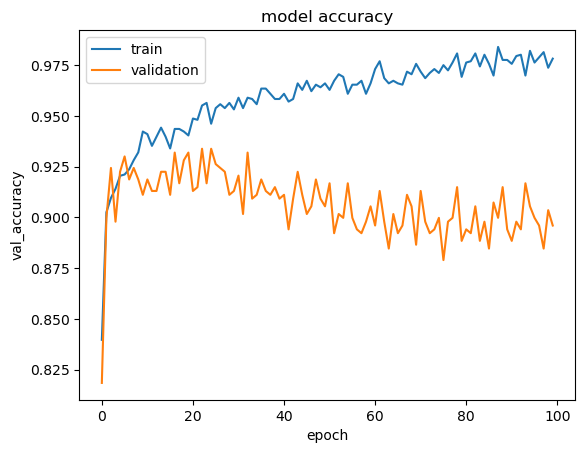

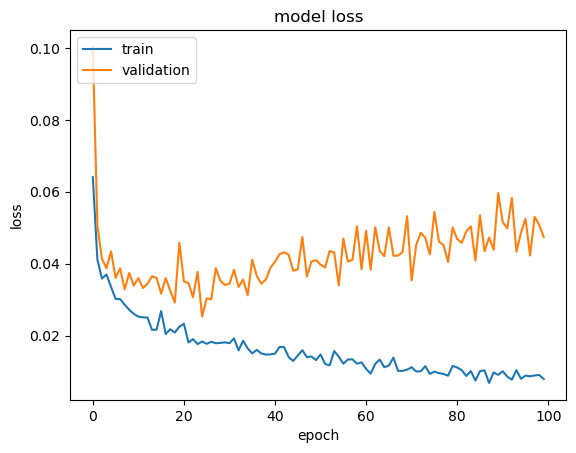

In [207]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
best_model_1 = keras.models.load_model("d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace/9-VGG19-YClahe-bin-98397-93384-100-epochs-multi-metrics/best_val_loss_weights.h5", custom_objects = { "weighted_binary_crossentropy" : weighted_binary_crossentropy })

In [34]:
#scoreSeg = model.evaluate_generator(test_generator, 400)
score_seg_1 = best_model_1.evaluate_generator(test_generator)

C:\Users\ax\AppData\Local\Temp\ipykernel_43728\4279285764.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_seg_1 = best_model_1.evaluate_generator(test_generator)


In [35]:
print(score_seg_1)
print(best_model_1.metrics_names)

[0.0388769768178463, 0.29411765933036804, 0.1515151560306549, 0.857740581035614, 0.8181818127632141, 0.9217221140861511]
['loss', 'precision_6', 'recall_6', 'specificity_at_sensitivity_6', 'sensitivity_at_specificity_6', 'accuracy']


In [37]:
best_model_2 = keras.models.load_model("d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace/9-VGG19-YClahe-bin-98397-93384-100-epochs-multi-metrics/best_val_accuracy_weights.h5", custom_objects = { "weighted_binary_crossentropy" : weighted_binary_crossentropy })

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4092] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
print(score_seg_2)
print(best_model_2.metrics_names)

In [ ]:
best_model_3 = keras.models.load_model("d:/Dane/ImageTagger/RetinopathyNonProfilerativeRadioButtons/Binary/workspace/9-VGG19-YClahe-bin-98397-93384-100-epochs-multi-metrics/best_accuracy_weights.h5", custom_objects = { "weighted_binary_crossentropy" : weighted_binary_crossentropy })

In [339]:
score_seg_2 = best_model_2.evaluate_generator(test_generator)

C:\Users\ax\AppData\Local\Temp\ipykernel_8156\908860726.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_seg_2 = best_model_2.evaluate_generator(test_generator)


In [340]:
score_seg_3 = best_model_3.evaluate_generator(test_generator)

C:\Users\ax\AppData\Local\Temp\ipykernel_8156\1932655602.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_seg_3 = best_model_3.evaluate_generator(test_generator)


In [341]:
print(score_seg_3)
print(best_model_3.metrics_names)

[0.02817726507782936, 0.908023476600647]
[0.03088008239865303, 0.9041095972061157]
[0.02344031259417534, 0.9178082346916199]


In [342]:
best_model_3.metrics_names

['loss', 'binary_accuracy']

In [36]:
cm = get_confusion_matrix(best_model_1, test_generator)

C:\Users\ax\AppData\Local\Temp\ipykernel_43728\3029224857.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data_generator)


In [37]:
cm

array([[478,   0],
       [ 33,   0]], dtype=int64)

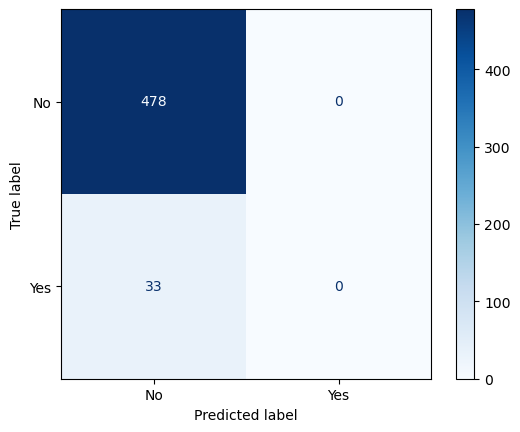

In [38]:
labels = ["No", "Yes"]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = plt.cm.Blues)
plt.show()